# Fast creation of an Observation FST using pywrapfst

As shown in this [example](http://localhost:8888/?token=1d421e6e15e54748d58a361f3f06b85702bcb690033af54d), it is convevient to interpret some specific structure as a particular FST. Creating manually an FST object from our data structure may be a very expensive operation. This notebook shows the a [beer](https://github.com/beer-asr/beer) specific extension of the [pywrapfst](https://github.com/beer-asr/pywrapfst) package. 

In [1]:
import numpy as np
import pywrapfst as fst

syms = fst.SymbolTable()

# We reserve the 0th index to the special epsilon symbol.
syms.add_symbol('ε')
for i in range(1000):
    syms.add_symbol(''.join(['s', str(i+1)]))

To implement a speech recognizer using FST operations, one needs to convert the output of the acoustic model into an FST. This FST models the log-likelihood of the observations given the possible states of the acoustic model. Let's denote this FST as an Observation FST. Common implementation (GMM/Neural Network...) will output the likelihood of the observations as a $N \times K$ matrix where $N$ is the number of observed features vectors and $K$ is the number of states in the model. The equivalent Observation FST will have $N + 1$ states and two consecutive states will have $K$ arcs - one for each model's state. Here is an implementation of the conversion between a matrix of observations' likelihood into an equivalent FST:

In [28]:
def get_fst_llhs(llhs):
    '''Convert a matrix of log-likelihoods into a FST.
    
    Args:
        llhs (numpy.ndarray): NxD matrix of log-likelihood.
     
    Returns:
        :class:`fst.Fst`: FST representing the log-likelihood matrix.
        
    '''
    # Create the FST
    llhs_fst = fst.Fst('log')
    
    # Create the states of the FST.
    states = [llhs_fst.add_state() for i in range(llhs.shape[0] + 1)]
    
    # Set initial and final states.
    llhs_fst.set_start(states[0]), llhs_fst.set_final(states[-1])
    
    # Create the arcs.
    for frame in range(llhs.shape[0]):
        for state in range(llhs.shape[1]):
            label = state + 1
            weight = fst.Weight(llhs_fst.weight_type(), -llhs[frame, state])
            arc = fst.Arc(label, label, weight, frame + 1)
            llhs_fst.add_arc(frame, arc)
        
    return llhs_fst

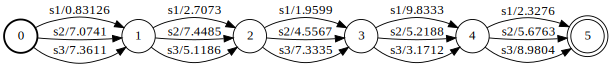

In [29]:
nframes = 5
nstates = 3
llhs = np.random.uniform(low=-10., high=0., size=(nframes, nstates))
llhs_fst = get_fst_llhs(llhs)
llhs_fst.set_input_symbols(syms), llhs_fst.set_output_symbols(syms)
llhs_fst

This implementation is quite inefficient as it requires to create an FST and to copy the matrix's data into the new FST. To avoid such bottleneck, beer's pywrapfst provide a specific object (```ObsFst```) that simply store the matrix of likelihood and behaves as an FST. The advantage of this object is that it does not make any copy of the data, rather it is just wraps the matrix in order to be interpreted as an FST.

In [30]:
help(fst.ObsFst)

Help on built-in function ObsFst in module pywrapfst:

ObsFst(...)
    Create an Observation FST.
    
    Args:
        data (:class:`np.ndarray`): The log-likelihood of the
            observations as a N x K matrix where N is the number of
            observations and K is the number of states in the model.
        isyms (fst.SymbolTable): Input symbol table.
        osyms (fst.SymbolTable): Output symbol table.
    
    Returns:
        (:class:`fst.Fst`): The FST representing the observations.



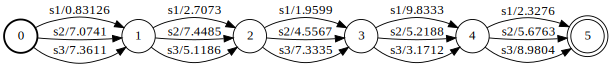

In [31]:
obs_fst = fst.ObsFst(llhs, syms, syms)
obs_fst

We can compare the speed difference between both implementations:

In [13]:
nstates=100
nframes=500
llhs = np.random.uniform(low=-10., high=0., size=(nframes, nstates))

In [14]:
%%timeit -n 10
get_fst_llhs(llhs)

10 loops, best of 3: 534 ms per loop


In [15]:
%%timeit -n 10
fst.ObsFst(llhs, syms, syms)

10 loops, best of 3: 1.57 µs per loop


That's it !